# Parse XML annotation file with X,Y coordinates and instance ID into a DataFrame

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

In [2]:
def xml_to_df(xml_filepath):

    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    classlist = []
    for Annotation in root.iter("Annotation"):
        for Attribute in Annotation.iter("Attribute"):
            classlist.append(Attribute.attrib.get('Name'))
    classlists = sorted(classlist)
    append_df = []
    for index, Annotation in enumerate(root.iter("Annotation")):
        for Region in Annotation.iter('Region'): #iterate over the Region so we can iterate over id 1 and 2 (two circles):
            x = np.array([Vertex.get('X') for Vertex in Region.iter('Vertex')])
            y = np.array([Vertex.get('Y') for Vertex in Region.iter('Vertex')])
            id = np.array([Region.get('Id')])
            classnames = classlists[index]
            coord_dict = {"ClassNames": [classnames], "X": [x], "Y": [y], "ID": [id]}
            df = pd.DataFrame(data = coord_dict)
            df.ID = df.ID.astype(int)
            append_df.append(df)
    coord_df = pd.concat(append_df).reset_index(drop=True)
    return(coord_df)

In [3]:
coord_df = xml_to_df(r'\\fatherserverdw\kyuex\clue images\annotations\roi\2022-06-07 13.18.40.xml')
coord_df

,ClassNames,X,Y,ID
0,tissue,"[5615, 5725, 5810, 5865, 5900, 5915, 5930, 594...","[10850, 10890, 10930, 10950, 10960, 10970, 109...",1
1,tissue,"[24299, 24364, 24483, 24537, 24613, 24624, 246...","[20025, 20068, 20133, 20176, 20209, 20231, 202...",2


# Convert X,Y Coordinates to Binary Mask and Read and Resize Image:

In [4]:
import openslide
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from matplotlib import pyplot as plt
def df_to_image_mask(xml_filepath, ndpi_filepath,downsample_factor):
    #global mask
    coord_df = xml_to_df(xml_filepath)
    slide = openslide.open_slide(ndpi_filepath)
    rgb_dim = slide.dimensions
    print("Dimension of level 0 of the image is: ",rgb_dim)
    slide_level_dim = slide.level_dimensions
    num_levels = len(slide_level_dim)
    print("Number of levels in this image are:",num_levels)
    factors = slide.level_downsamples
    print("Each level is downsampled by:",factors)
    blank = np.zeros(rgb_dim, dtype = np.uint8) #white
    for idx, row in coord_df.iterrows():
        xx = row.X
        yy = row.Y
        xy = list(zip(xx,yy))
        contours = np.array(xy)
        mask = cv2.fillPoly(blank, pts=[contours.astype(int)], color=idx+1)
    target_level = slide.get_best_level_for_downsample(downsample_factor)
    target_dim = slide.level_dimensions[target_level]
    rsf = [x/y for x,y in zip(rgb_dim,target_dim)]
    image_resized = slide.read_region(location=(0,0),level=target_level,size=target_dim)
    mask_resized = cv2.resize(mask,[_//round(rsf[0]) for _ in mask.shape],interpolation=cv2.INTER_NEAREST)
    return image_resized,mask_resized

# Cropping RGB Image with Mask:

In [5]:
image,mask = df_to_image_mask(r'\\fatherserverdw\kyuex\clue images\annotations\roi\2022-06-07 13.18.40.xml',r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi',10)

Dimension of level 0 of the image is:  (48000, 47872)
Number of levels in this image are: 8
Each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)


In [6]:
def crop_final_mask(image,mask):
    imagearr = np.array(image)
    imagearr = imagearr[:,:,:3]
    maskarr = np.array(mask)
    maskrgb = np.repeat(maskarr[:,:,np.newaxis],3,axis=2)
    for tissueID in range(1,np.max(maskrgb[:])): #from first tissue id to end
        #masking
        masktmp = mask==tissueID #boolean
        masktmp = np.repeat(masktmp[:,:,np.newaxis],3,axis=2) #change shape to match shape of imagearr
        final_image = np.multiply(imagearr,masktmp)
        #crop
        [x_crop,y_crop] = np.where(final_image[:,:,0]>0)
        cropped_final_image = final_image[np.min(y_crop):np.max(y_crop),np.min(x_crop):np.max(x_crop)]
        cropped_final_image = cropped_final_image[:,:,::-1]
        return cropped_final_image
        #cv2.imwrite(r"\\fatherserverdw\Kevin\\" + "final_image" + str(tissueID) + ".jpg",cropped_final_image)

In [7]:
crop_final_mask(image,mask)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Now create mask for multiple annotation classes:

In [8]:
coord_df_1 = xml_to_df(r'\\fatherserverdw\kyuex\clue images\annotations\12class\2022-06-07 13.18.40.xml')
coord_df_1

,ClassNames,X,Y,ID
0,bloodvessel,"[7833, 7833, 7833, 7834, 7834, 7835, 7835, 783...","[6594, 6593, 6592, 6592, 6591, 6591, 6589, 658...",1
1,bloodvessel,"[8596, 8597, 8597, 8598, 8598, 8600, 8600, 860...","[6019, 6019, 6018, 6015, 6014, 6014, 6013, 601...",2
2,bloodvessel,"[10214, 10215, 10215, 10215, 10216, 10216, 102...","[4918, 4918, 4915, 4914, 4914, 4913, 4913, 491...",3
3,bloodvessel,"[8993, 8992, 8991, 8990, 8990, 8989, 8988, 898...","[5313, 5313, 5313, 5313, 5315, 5315, 5315, 531...",4
4,bloodvessel,"[7521, 7521, 7521, 7521, 7521, 7522, 7522, 752...","[7007, 7006, 7004, 7003, 7002, 7002, 7001, 700...",5
...,...,...,...,...
144,white,"[33402, 33404, 33405, 33406, 33406, 33407, 334...","[20590, 20590, 20590, 20590, 20591, 20591, 205...",17
145,white,"[39948, 39955, 39959, 39970, 39981, 39989, 400...","[39749, 39749, 39749, 39749, 39749, 39752, 397...",18
146,white,"[39193, 39189, 39185, 39181, 39178, 39178, 391...","[37963, 37963, 37974, 37978, 37982, 37986, 379...",19
147,white,"[39767, 39769, 39770, 39772, 39773, 39774, 397...","[38084, 38084, 38084, 38085, 38085, 38086, 380...",20


In [26]:
from sklearn.preprocessing import LabelEncoder
coord_df_1 = xml_to_df(r'\\fatherserverdw\kyuex\clue images\annotations\12class\2022-06-07 13.18.40.xml')
slide = openslide.open_slide(r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi')
rgb_dim = slide.dimensions
blank = np.zeros(rgb_dim, dtype = np.uint8)
le = LabelEncoder()
coord_df_1["ClassLabels"] = le.fit_transform(coord_df_1.ClassNames.values)
nlabels = coord_df_1.ClassLabels.nunique()

for label in range(nlabels):
    dflabel = coord_df_1.iloc[0:coord_df_1[coord_df_1.ClassLabels == label].index[0]]
    #print(dflabel)



TypeError: 'builtin_function_or_method' object is not subscriptable

In [10]:
image1, mask1 = df_to_image_mask(r'\\fatherserverdw\kyuex\clue images\annotations\12class\2022-06-07 13.18.40.xml',r'\\fatherserverdw\kyuex\clue images\2022-06-07 13.18.40.ndpi',10)

Dimension of level 0 of the image is:  (48000, 47872)
Number of levels in this image are: 8
Each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)


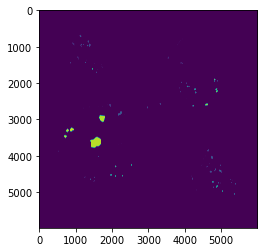

In [11]:
plt.imshow(mask1)

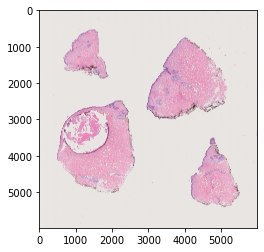

In [12]:
plt.imshow(image1)

In [13]:
image2 = crop_final_mask(image1,mask1)

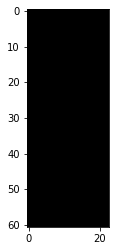

In [14]:
plt.imshow(image2
           )